# ARIMA

간단한 데이터셋을 기반으로 본격적으로 ARIMA 기법을 실습해 보겠습니다.

(참고)
https://www.analyticsvidhya.com/blog/2016/02/time-series-forecasting-codes-python/

사용하고 있는 데이터는 1949년부터 1960년까지 총 12년(144개월) 동안 매월 항공기 승객 수의 증감 추이를 나타내는 Univariate Time Series입니다.
이번 실습에서는 앞부분 10년(1949~1958년)간의 승객수 변화 패턴을 통해 이후 2년(1959~1960년)간의 승객 수를 예측하는 모델의 정확도를 정량적으로 계산해 보겠습니다.

앞서 살펴보았던 Decomposing을 통해, Residual이 매우 작고 강하게 stationary하다면,   
Residual을 white noise 수준으로 무시해 버리고, Trend나 Seasonality같은 component만 사용해도 time series forcasting이 가능합니다.  
그러나 그런 경우는 매우 드물기 때문에 ARIMA와 같이 시간의 변화에 따른 data간 dependency를 살펴보는 기법이 유용하게 사용됩니다.

ARIMA에는 3가지 파라미터가 존재합니다. 

1. Number of AR (Auto-Regressive) terms (p): lags of dependent variable
  p=5라면 x(t)를 예측하기 위해 x(t-1)….x(t-5)를 참조하게 됩니다.
2. Number of MA (Moving Average) terms (q): lags of dependent error  
  q=5라면 x(t)를 예측하기 위해 e(t-1)….e(t-5)를 참조하게 됩니다.
3. Number of Differences (d): These are the number of nonseasonal differences,   
i.e. in this case we took the first order difference. So either we can pass that variable and put d=0 or pass the original variable and put d=1. Both will generate same results.

이 파라미터 중 적절한 p와 q를 선택하기 위해서, lag을 증가시켜 가며 t-lag,..., t-1까지의 이전 데이터들과 x(t) 사이의 correlation을 따져보는 방법(Autocorrelation, 자기상관성)을 사용합니다.   
correlation이 0에 근접할 수록 서로 독립적이므로 자기상관성이 낮고 stationality가 높다고 볼 수 있습니다.  

ACF(Autocorrelation Function, 자기상관계수 함수) : lag=k일 때 ρk 는 시각 t의 값 Yt와 시각 t−k의 값 Yt−k의 correlation  
PACF(Partial ACF, 편자기상관계수 함수 ) : ACF에서 시각 t-1부터 t-k+1 사이의 값의 영향도를 배제했을 때의 correlation   

그렇다면 주어진 데이터셋에 대해 ACF와 PACF를 플롯팅해 보면 적절한 p와 q를 선택할 수 있을 것입니다.

In [45]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import acf, pacf

In [46]:
# csv 포맷의 데이터 경로를 지정합니다.
dataset_filepath = 'datasets/airline-passengers.csv'

In [47]:
# Read data , get stationary TS with log-transform and differencing
ts = pd.read_csv(dataset_filepath, index_col='Month', parse_dates=True)

ts_train = ts['1949':'1958']
ts_test = ts['1959':'1960']

ts_log = np.log(ts_train)
ts_log_shift = ts_log.shift() 
ts_log_diff = ts_log - ts_log_shift
ts_log_diff.dropna(inplace=True)

In [48]:
lag_acf = acf(ts_log_diff, nlags=20)
lag_pacf = pacf(ts_log_diff, nlags=20, method='ols')

Text(0.5, 1.0, 'Partial Autocorrelation Function')

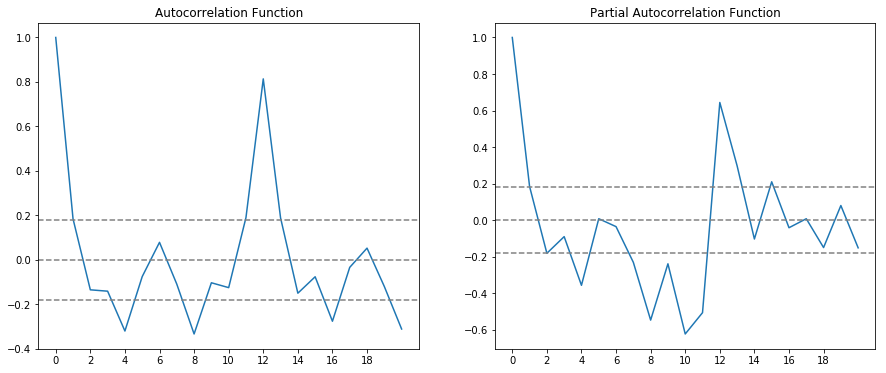

In [49]:
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 6    # matlab 차트의 기본 크기를 15,6으로 지정해 줍니다.
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

#Plot ACF: 
plt.subplot(121) 
plt.plot(lag_acf)
plt.xticks(np.arange(0, 20, 2.0))
# For confidence intervals
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_log_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_log_diff)),linestyle='--',color='gray')
plt.title('Autocorrelation Function')

#Plot PACF:
plt.subplot(122)
plt.plot(lag_pacf)
plt.xticks(np.arange(0, 20, 2.0))
# For confidence intervals
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_log_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_log_diff)),linestyle='--',color='gray')
plt.title('Partial Autocorrelation Function')

PACF를 통해 p 값을, ACF를 통해 q 값을 정하는 것이 일반적입니다. 이 경우에는 p=2, q=2 혹은 p=5, q=5가 적당해 보입니다.  
이번에는 d=1로 하여 1st order diffence만 고려하도록 하겠습니다.

In [50]:
from statsmodels.tsa.arima_model import ARIMA

#### AR Model

C:\Users\uhmpp\Anaconda3\envs\tf13\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\uhmpp\Anaconda3\envs\tf13\lib\site-packages\statsmodels\tsa\base\tsa_model.py:191: FutureWarning: Creating a DatetimeIndex by passing range endpoints is deprecated.  Use `pandas.date_range` instead.
  start=index[0], end=index[-1], freq=freq)
C:\Users\uhmpp\Anaconda3\envs\tf13\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Text(0.5, 1.0, 'RSS: 1.0824')

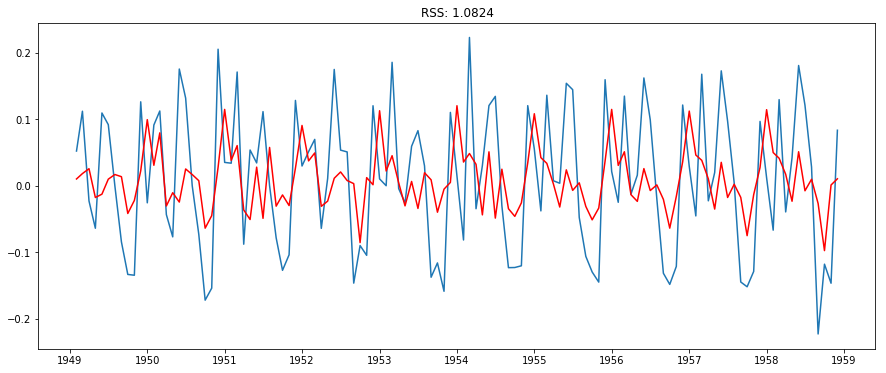

In [51]:
model = ARIMA(ts_log, order=(5, 1, 0))  
results_AR = model.fit(disp=-1)  
plt.plot(ts_log_diff)
plt.plot(results_AR.fittedvalues, color='red')

plt.title('RSS: %.4f'% sum((results_AR.fittedvalues-ts_log_diff.iloc[:,0])**2))

#### MA Model

C:\Users\uhmpp\Anaconda3\envs\tf13\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\uhmpp\Anaconda3\envs\tf13\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Text(0.5, 1.0, 'RSS: 0.8839')

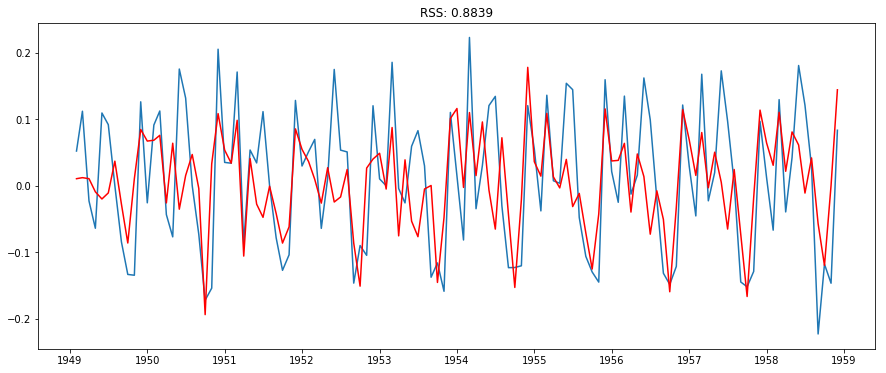

In [52]:
model = ARIMA(ts_log, order=(0, 1, 5))  
results_MA = model.fit(disp=-1)  
plt.plot(ts_log_diff)
plt.plot(results_MA.fittedvalues, color='red')

plt.title('RSS: %.4f'% sum((results_MA.fittedvalues-ts_log_diff.iloc[:,0])**2))

#### ARIMA combined model

C:\Users\uhmpp\Anaconda3\envs\tf13\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\uhmpp\Anaconda3\envs\tf13\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\uhmpp\Anaconda3\envs\tf13\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


Text(0.5, 1.0, 'RSS: 0.6911')

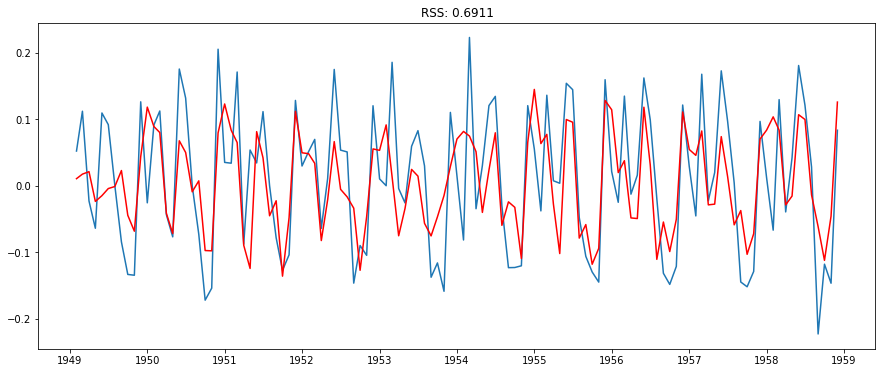

In [53]:
model = ARIMA(ts_log, order=(5, 1, 5))  
results_ARIMA = model.fit(disp=-1)  
plt.plot(ts_log_diff)
plt.plot(results_ARIMA.fittedvalues, color='red')

plt.title('RSS: %.4f'% sum((results_ARIMA.fittedvalues-ts_log_diff.iloc[:,0])**2))

지금까지 우리는 stationality 확보를 위해 log scale로 transform한 데이터를 다루어 왔습니다.   
그러나 최종적인 prediction 및 결과분석은 original data scale로 진행해야 합니다.

In [54]:
predictions_ARIMA_diff = pd.Series(results_ARIMA.fittedvalues, copy=True)
predictions_ARIMA_diff.head()

Month
1949-02-01    0.010618
1949-03-01    0.017445
1949-04-01    0.021144
1949-05-01   -0.023657
1949-06-01   -0.014945
dtype: float64

In [55]:
predictions_ARIMA_diff_cumsum = predictions_ARIMA_diff.cumsum()    # Cumulative Sum : opposite of diffencing
predictions_ARIMA_diff_cumsum.head()

Month
1949-02-01    0.010618
1949-03-01    0.028063
1949-04-01    0.049207
1949-05-01    0.025550
1949-06-01    0.010604
dtype: float64

In [56]:
predictions_ARIMA_log = pd.Series(ts_log.iat[0,0], index=ts_log.index)
predictions_ARIMA_log = predictions_ARIMA_log.add(predictions_ARIMA_diff_cumsum,fill_value=0)
predictions_ARIMA_log.head()

Month
1949-01-01    4.718499
1949-02-01    4.729117
1949-03-01    4.746562
1949-04-01    4.767706
1949-05-01    4.744048
dtype: float64

Text(0.5, 1.0, 'RMSE: 116.7695')

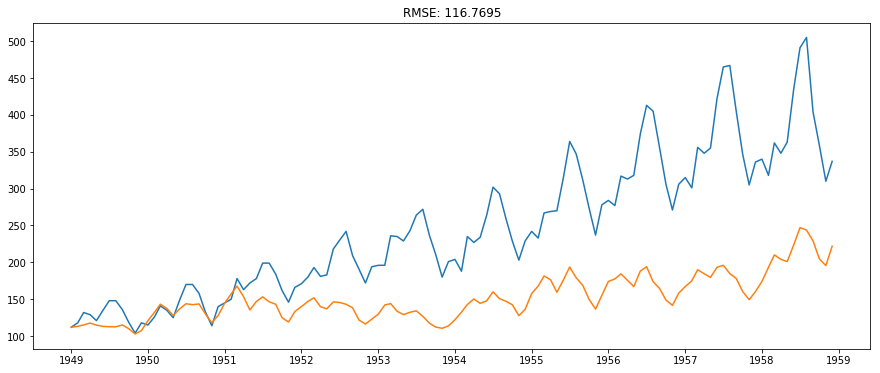

In [58]:
predictions_ARIMA = np.exp(predictions_ARIMA_log)
plt.plot(ts_train)
plt.plot(predictions_ARIMA)
plt.title('RMSE: %.4f'% np.sqrt(sum((predictions_ARIMA-ts_train.iloc[:,0])**2)/len(ts_train)))

ARIMA를 이용하여 현재의 시계열 데이터를 가장 잘 설명하는 모델을 찾으려 하였으나 정확도가 그리 높지 않았다.  
증감의 패턴은 유사하게 찾아냈으나, Trend를 정확하게 파악하는데 실패하였다.

#### Forcasting with Test-set

In [59]:
forcast_ARIMA_diff = results_ARIMA.predict(start='1959-01-01', end='1960-12-01')

C:\Users\uhmpp\Anaconda3\envs\tf13\lib\site-packages\statsmodels\tsa\base\tsa_model.py:336: FutureWarning: Creating a DatetimeIndex by passing range endpoints is deprecated.  Use `pandas.date_range` instead.
  freq=base_index.freq)
C:\Users\uhmpp\Anaconda3\envs\tf13\lib\site-packages\statsmodels\tsa\base\tsa_model.py:320: FutureWarning: Creating a DatetimeIndex by passing range endpoints is deprecated.  Use `pandas.date_range` instead.
  freq=base_index.freq)


In [61]:
forcast_ARIMA_diff.head()

1959-01-01    0.147773
1959-02-01    0.131658
1959-03-01    0.035226
1959-04-01   -0.068519
1959-05-01   -0.023313
Freq: MS, dtype: float64

In [62]:
forcast_ARIMA_diff_cumsum = forcast_ARIMA_diff.cumsum()    # Cumulative Sum : opposite of diffencing
forcast_ARIMA_diff_cumsum.head()

1959-01-01    0.147773
1959-02-01    0.279431
1959-03-01    0.314657
1959-04-01    0.246138
1959-05-01    0.222825
Freq: MS, dtype: float64

In [68]:
forcast_ARIMA_log = pd.Series(ts_log.iat[-1,0], index=ts_test.index)
forcast_ARIMA_log = forcast_ARIMA_log.add(forcast_ARIMA_diff_cumsum,fill_value=0)
forcast_ARIMA_log.head()

Month
1959-01-01    5.967856
1959-02-01    6.099514
1959-03-01    6.134740
1959-04-01    6.066221
1959-05-01    6.042908
dtype: float64

Text(0.5, 1.0, 'RMSE: 76.2317')

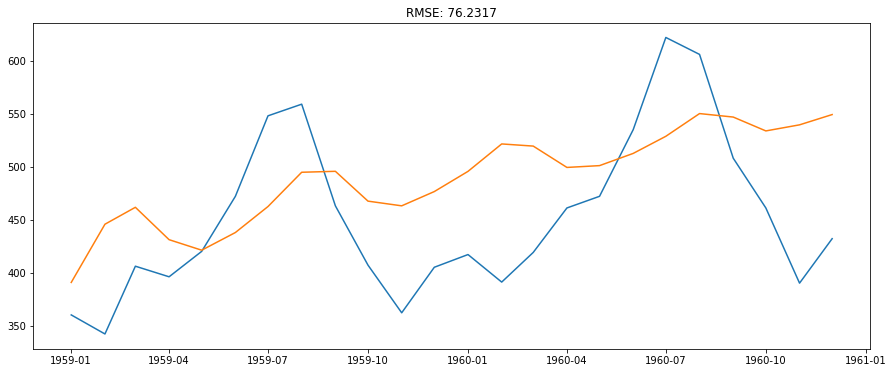

In [69]:
forcast_ARIMA = np.exp(forcast_ARIMA_log)
plt.plot(ts_test)
plt.plot(forcast_ARIMA)
plt.title('RMSE: %.4f'% np.sqrt(sum((forcast_ARIMA-ts_test.iloc[:,0])**2)/len(ts_test)))